In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import re
import torch.nn.functional as F
from torch.optim import Adam
from tqdm.auto import trange
import torch.nn as nn
from glob import glob
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from dgl.dataloading import GraphDataLoader

from cloudmanufacturing.data import read_fatahi_dataset
from cloudmanufacturing.graph import dglgraph, graph_gamma, os_type, so_type, ss_type
from cloudmanufacturing.graphconv import GNN
from cloudmanufacturing.solvers.mip_solver import mip_solve
from cloudmanufacturing.validation import construct_delta, objvalue, construct_delta2

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

c:\Users\dmitrii\miniconda3\envs\graph\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


device(type='cuda')

In [2]:
train_problems = read_fatahi_dataset("../data/train_data.xlsx")
test_problems = read_fatahi_dataset("../data/fatahi.xlsx")

100%|██████████| 18/18 [00:00<?, ?it/s]


In [3]:
def dglgraph_fixed(graph, oper_max=20):
        ncolumns = graph.ndata['feat']['o'].shape[1]
        graph.ndata['feat'] = {'o': F.pad(graph.ndata['feat']['o'], [0, oper_max - ncolumns])}
        return graph

In [4]:
class GraphDataset(Dataset):
    def __init__(self, problems, gammas, deltas):
        self.problems = problems
        self.gammas = gammas
        self.deltas = deltas

    def __len__(self):
        return len(self.problems)

    def __getitem__(self, idx):
        problem = self.problems[idx]
        gamma = self.gammas[idx]
        delta = self.deltas[idx]
        graph = dglgraph(problem, gamma, delta)
        graph = dglgraph_fixed(graph)
        # graph.edata["feat"][os_type][:, 0] /= 10
        # graph.edata["feat"][ss_type] /= 100
        return graph.to(device)

In [5]:
info_train = {}
for delta, gamma, idx in zip([i for i in glob('train_solutions/*') if 'delta' in i],
                             [i for i in glob('train_solutions/*') if 'gamma' in i],
                             [int(i.split('_')[-2]) for i in glob('train_solutions/*') if 'gamma' in i]):
    info_train[idx] = {}
    info_train[idx]['gamma'] = np.load(gamma)
    info_train[idx]['delta'] = np.load(delta)
    info_train[idx]['problem'] = train_problems[idx]

info_test = {}
for delta, gamma, idx in zip([i for i in glob('fatahi_solutions/*') if 'delta' in i],
                             [i for i in glob('fatahi_solutions/*') if 'gamma' in i],
                             [int(i.split('_')[-2]) for i in glob('fatahi_solutions/*') if 'gamma' in i]):
    info_test[idx] = {}
    info_test[idx]['gamma'] = np.load(gamma)
    info_test[idx]['delta'] = np.load(delta)
    info_test[idx]['problem'] = test_problems[idx]

In [6]:
train_idx, test_idx = train_test_split(list(info_train.keys()),
                                       random_state=42,train_size=0.7)

In [7]:
train_dataset = GraphDataset([info_train[i]['problem'] for i in train_idx],
                             [info_train[i]['gamma'] for i in train_idx],
                             [info_train[i]['delta'] for i in train_idx])

test_dataset = GraphDataset([info_train[i]['problem'] for i in test_idx],
                             [info_train[i]['gamma'] for i in test_idx],
                             [info_train[i]['delta'] for i in test_idx])

# train_dataset = GraphDataset([info_train[i]['problem'] for i in sorted(info_train.keys())],
#                              [info_train[i]['gamma'] for i in sorted(info_train.keys())],
#                              [info_train[i]['delta'] for i in sorted(info_train.keys())])

# test_dataset = GraphDataset([info_test[i]['problem'] for i in sorted(info_test.keys())],
#                              [info_test[i]['gamma'] for i in sorted(info_test.keys())],
#                              [info_test[i]['delta'] for i in sorted(info_test.keys())])

In [8]:
train_loader = GraphDataLoader(train_dataset, batch_size=30, shuffle=True)
test_loader = GraphDataLoader(test_dataset, batch_size=10, shuffle=True)

In [9]:
from joblib import Parallel, delayed

def validate_objective(model, dataset):
    # test_objvalue = []
    # for i in range(len(dataset.problems)):
    #     pred_gamma, pred_delta = model.predict(dataset.__getitem__(i), dataset.problems[i])
    #     test_objvalue.append(
    #         objvalue(dataset.problems[i], pred_gamma, pred_delta)
    #     )
    def process_objective(model, dataset, i):
        pred_gamma, pred_delta = model.predict(dataset.__getitem__(i), dataset.problems[i])
        return objvalue(dataset.problems[i], pred_gamma, pred_delta)
    
    test_objvalue = Parallel(n_jobs=-1)(
        delayed(process_objective)(model, dataset, i) for i in range(len(dataset.problems))
    )
    return np.mean(test_objvalue)

In [10]:
i=0
gamma = info_train[i]['gamma']
delta = info_train[i]['delta']
problem = train_problems[i]

print(problem['operations'])
print(gamma.sum())
print(delta.sum())

[[1. 0. 0. 1. 1.]
 [1. 0. 1. 0. 1.]
 [1. 1. 0. 1. 0.]
 [1. 1. 1. 1. 1.]
 [0. 1. 1. 1. 0.]
 [0. 1. 1. 0. 0.]]
19.0
12.0


In [11]:
idx=5
gamma = info_train[idx]['gamma']
delta = info_train[idx]['delta']
for op_num in range(train_problems[idx]['operations'].shape[1]):
    city_list = []
    for i, sub_op in enumerate(np.nonzero(train_problems[idx]['operations'][:,op_num])[0]):
        c = np.nonzero(gamma[sub_op, op_num,:])
        city_list.append(c)
        if i != 0:
            print(city_list[i-1][0], c[0])
            print(delta[:,city_list[i-1],c,sub_op,op_num].reshape(-1))
    print('\n')

[3] [13]
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[13] [9]
[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
[9] [9]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


[9] [13]
[0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
[13] [9]
[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]


[5] [5]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[5] [0]
[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]


[9] [11]
[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
[11] [13]
[0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
[13] [9]
[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]


[11] [8]
[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
[8] [9]
[0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]


[7] [11]
[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
[11] [13]
[0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
[13] [9]
[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
[9] [9]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]




In [12]:
def print_all(loss_list_train, loss_list_test,
              objvalue_train, objvalue_test):
    plt.plot(loss_list_train, label='train loss')
    plt.plot(loss_list_test, label='test loss')
    plt.legend()
    plt.show()

    plt.plot(objvalue_train, label='train objective')
    plt.plot(objvalue_test, label='test objective')
    plt.legend()
    plt.show()

In [13]:
def run_experiment(out_dim=15, lr=1e-4):
    model = GNN(s_shape=1, o_shape=20, os_shape=2,
            ss_shape=10, out_dim=out_dim, n_layers=1).to(device)
    optim = Adam(model.parameters(), lr=lr)

    loss_list_train = []
    objvalue_train = []
    loss_list_test = []
    objvalue_test = []
    for epoch in trange(100):
            ep_loss_train = []
            ep_loss_test = []
            for graph in train_loader:
                optim.zero_grad()
                # take initial info
                gamma_target = graph.edata["target"][os_type]
                delta_target = graph.edata["delta_target"][ss_type]
                mask = graph.edata["mask"][ss_type]
                # Forward pass
                logits, delta_logits = model(graph)
                # loss calculation
                operation_loss = F.binary_cross_entropy_with_logits(logits, gamma_target)
                service_loss = F.cross_entropy(delta_logits[mask.bool()],
                                            delta_target[mask.bool()])

                loss = operation_loss + service_loss*0.5
                loss.backward()
                optim.step()
                ep_loss_train.append(loss.item())

            for graph in test_loader:
                with torch.no_grad():
                    # take initial info
                    gamma_target = graph.edata["target"][os_type]
                    delta_target = graph.edata["delta_target"][ss_type]
                    mask = graph.edata["mask"][ss_type]
                    # Forward pass
                    logits, delta_logits = model(graph)
                    # loss calculation
                    operation_loss = F.binary_cross_entropy_with_logits(logits, gamma_target)
                    service_loss = F.cross_entropy(delta_logits[mask.bool()],
                                                delta_target[mask.bool()])
                    loss = operation_loss + service_loss*0.5
                    ep_loss_test.append(loss.item())

            loss_list_train.append(np.mean(ep_loss_train))
            loss_list_test.append(np.mean(ep_loss_test))

            if (epoch + 1) % 10 == 0:
                objvalue_train.append(validate_objective(model, train_dataset))
                objvalue_test.append(validate_objective(model, test_dataset))

    print_all(loss_list_train, loss_list_test,
              objvalue_train, objvalue_test)

5 0.01


  0%|          | 0/100 [00:00<?, ?it/s]c:\Users\dmitrii\miniconda3\envs\graph\lib\site-packages\dgl\backend\pytorch\tensor.py:449: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  assert input.numel() == input.storage().size(), (
  9%|▉         | 9/100 [00:17<03:01,  2.00s/it]c:\Users\dmitrii\miniconda3\envs\graph\lib\site-packages\joblib\externals\loky\process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
100%|██████████| 100/100 [04:51<00:00,  2.91s/it]


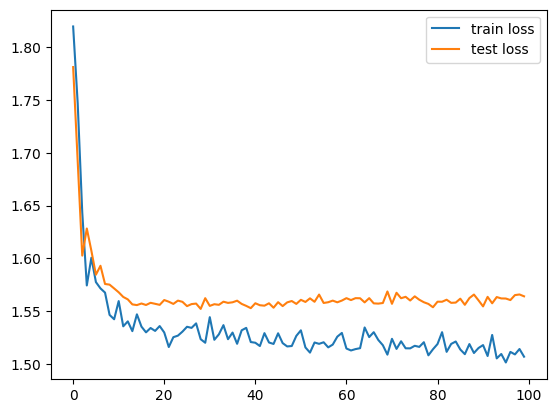

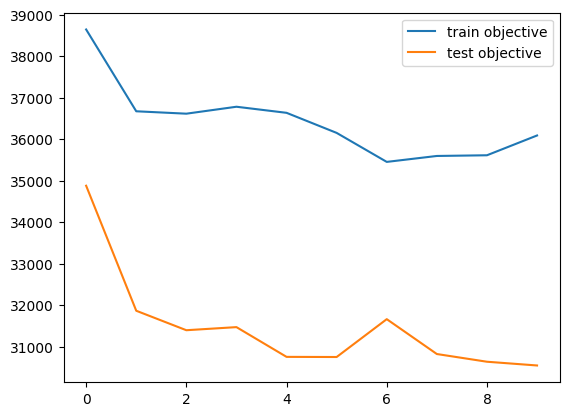

5 0.001


100%|██████████| 100/100 [04:35<00:00,  2.75s/it]


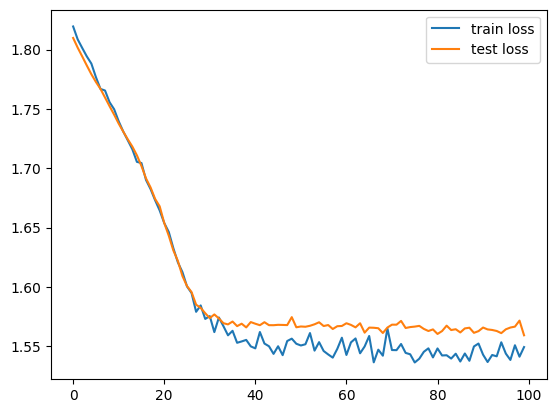

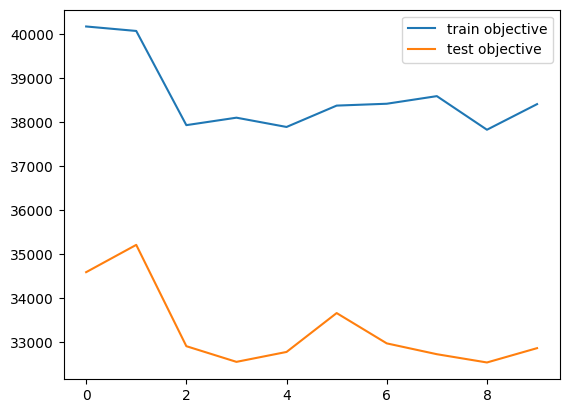

5 0.0001


100%|██████████| 100/100 [04:49<00:00,  2.90s/it]


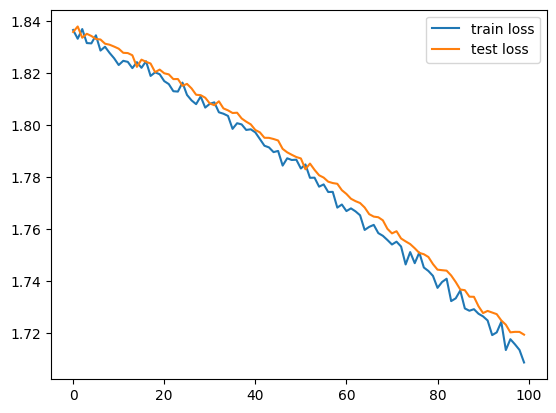

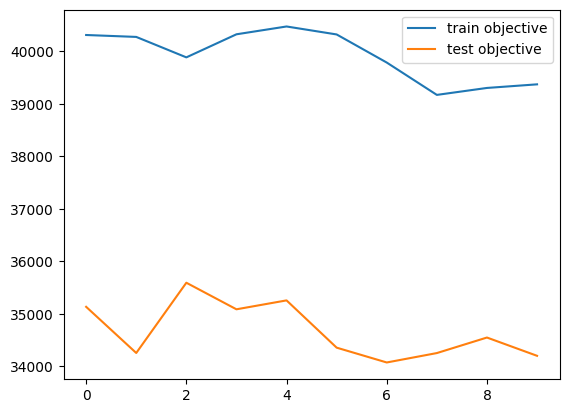

5 1e-05


100%|██████████| 100/100 [04:45<00:00,  2.85s/it]


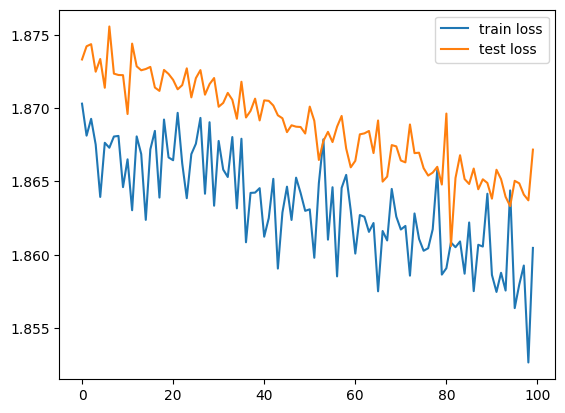

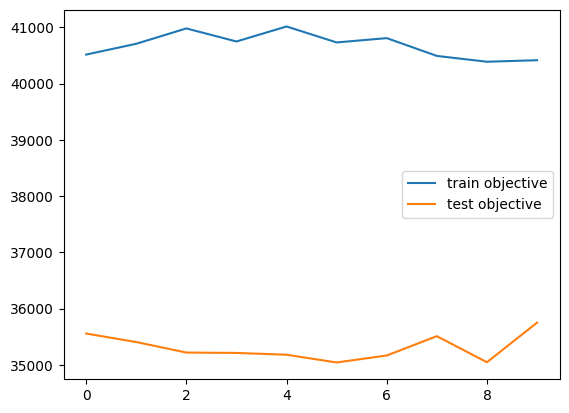

10 0.01


100%|██████████| 100/100 [04:34<00:00,  2.75s/it]


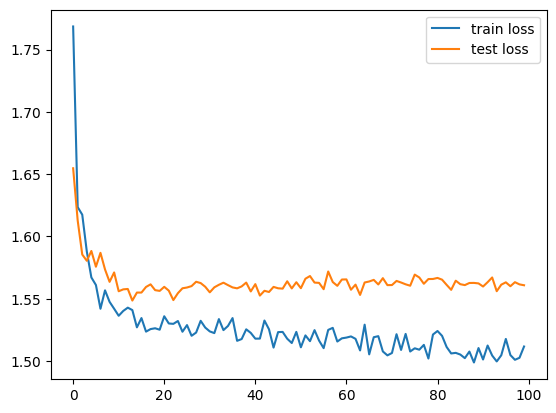

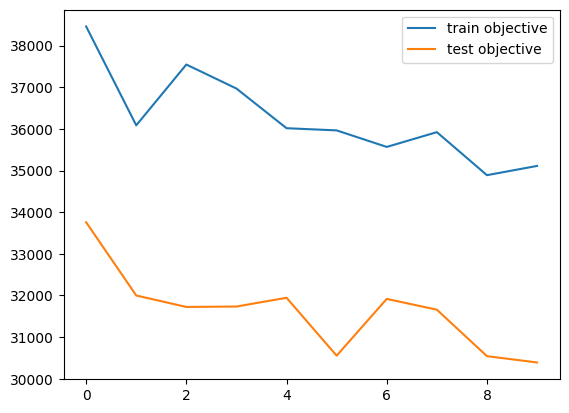

10 0.001


100%|██████████| 100/100 [04:30<00:00,  2.71s/it]


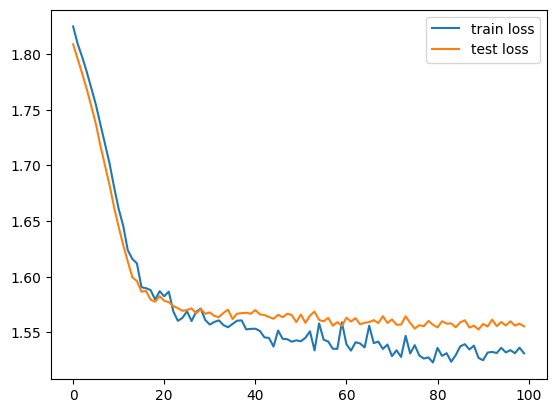

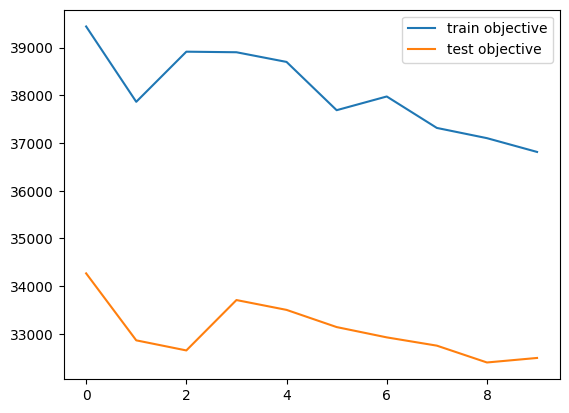

10 0.0001


100%|██████████| 100/100 [04:40<00:00,  2.81s/it]


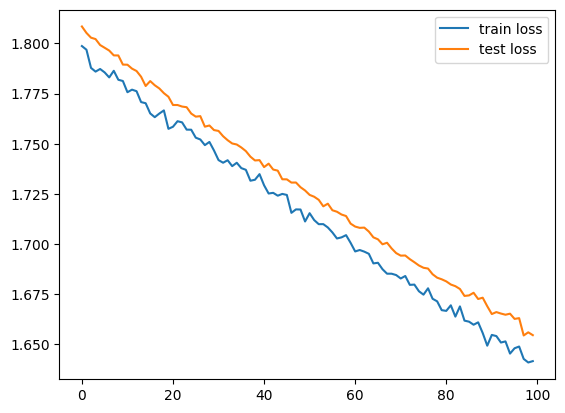

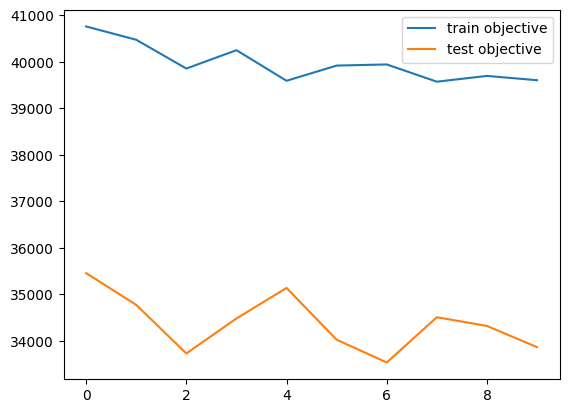

10 1e-05


100%|██████████| 100/100 [04:34<00:00,  2.74s/it]


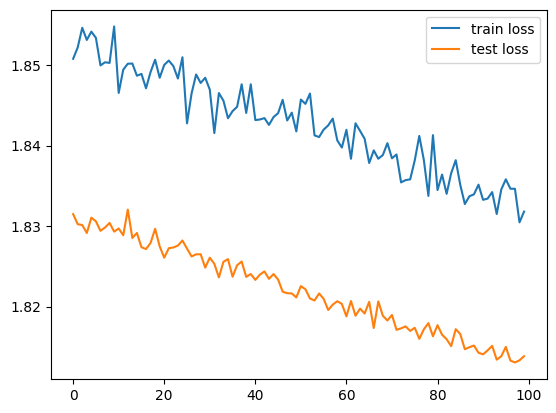

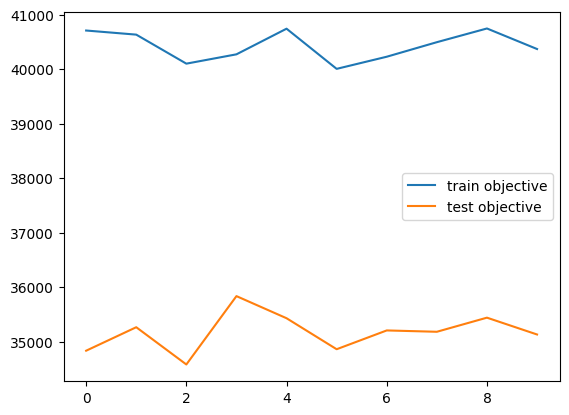

15 0.01


100%|██████████| 100/100 [04:40<00:00,  2.80s/it]


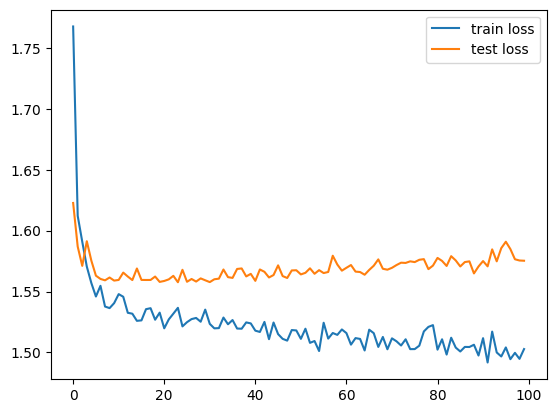

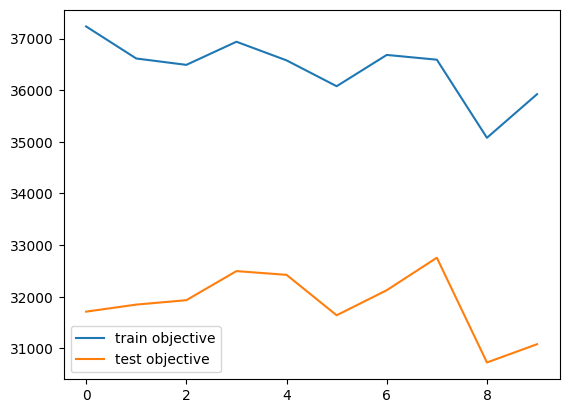

15 0.001


 30%|███       | 30/100 [01:24<05:37,  4.82s/it]

In [14]:
for dim in [5,10,15,20,30]:
    for lr in [1e-2, 1e-3, 1e-4, 1e-5]:
        print(dim, lr)
        run_experiment(out_dim=dim, lr=lr)

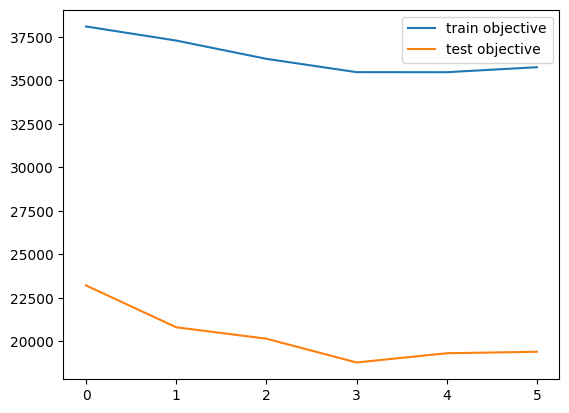

In [ ]:
plt.plot(objvalue_train, label='train objective')
plt.plot(objvalue_test, label='test objective')
plt.legend()
plt.show()

In [ ]:
def train_model(graph_loader, dataset, model, num_epoch,
                info={}, suffix='train', train=True):
    loss_list = []
    objvalue = []
    for epoch in range(num_epoch):
        ep_loss = []
        for graph in graph_loader:
            optim.zero_grad()
            # take initial info
            gamma_target = graph.edata["target"][os_type]
            delta_target = graph.edata["delta_target"][ss_type]
            mask = graph.edata["mask"][ss_type]
            # Forward pass
            logits, delta_logits = model(graph)
            # loss calculation
            operation_loss = F.binary_cross_entropy_with_logits(logits, gamma_target)
            service_loss = F.cross_entropy(delta_logits[mask], delta_target[mask])
            loss = operation_loss + service_loss
            loss.backward()
            optim.step()
            ep_loss.append(loss.item())
        loss_list.append(np.mean(ep_loss))
        

        if (epoch + 1) % 10 == 0:
            objvalue.append(validate_objective(model, dataset))
    info[f'{suffix}_loss'] = loss_list
    info[f'{suffix}_objvalue'] = objvalue
    return info

In [ ]:
for i in trange(15):
    model.train()
    info = train_model(train_loader, train_dataset, model, 10)
    model.eval()
    with torch.no_grad():
        info = train_model(test_loader, test_dataset, model, 10,
                        info=info, suffix='test', train=False)

  0%|          | 0/15 [00:26<?, ?it/s]


RuntimeError: element 0 of tensors does not require grad and does not have a grad_fn

In [ ]:
print_info(info)

In [ ]:
# problem = dataset[0]
# a = generate_tariff_matrix(problem['n_services'],
#                        problem['dist'],
#                        problem['productivity']/100,
#                        problem['op_cost'])